In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Important:

1.The given image files were in dimension (2026,620,3) which is very big so i have converted them to (128, 384,3).

2. Also threre are 440 images with 24 classes so when using all of the images i have run out of my RAM so i have only used 200 images.

In [3]:
#link the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#path of the files
train_input_path = './gdrive/MyDrive/bigthinx_ai_challange/train/'
train_labels_path = './gdrive/MyDrive/bigthinx_ai_challange/train_labels/'
train_labels_ids_path = 'gdrive/MyDrive/bigthinx_ai_challange/train_labels_ids/'

In [111]:
#Function to read images
def read(i,filepath):
    img = tf.keras.preprocessing.image.load_img(filepath, target_size = (128,384))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img.astype('float32')
    img = img / 255.0
    return img

In [143]:
#function to read image labels
def read_label(i, filepath):
    img = tf.keras.preprocessing.image.load_img(filepath, target_size = (128,384), color_mode = 'grayscale') #color_mode = 'grayscale'
    img = tf.keras.preprocessing.image.img_to_array(img)
    return img

In [34]:
X_train_path = [os.path.join(train_input_path, x) for x in os.listdir(train_input_path)][:200]
Y_train_id_path = [os.path.join(train_labels_ids_path, x) for x in os.listdir(train_input_path)][:200]

In [113]:
X_train = np.array([read(i, path) for i, path in enumerate(X_train_path)])

In [114]:
Y_train_id = np.array([read_label(i, path) for i, path in enumerate(Y_train_id_path)])
Y_train_id = np.where(Y_train_id == 255,23,Y_train_id)

In [38]:
Y_train_id = tf.one_hot(np.array(Y_train_id).reshape(200,128,384), 24)
np.unique(Y_train_id)

array([0., 1.], dtype=float32)

In [39]:
Y_train_id.shape

TensorShape([200, 128, 384, 24])

(-0.5, 383.5, 127.5, -0.5)

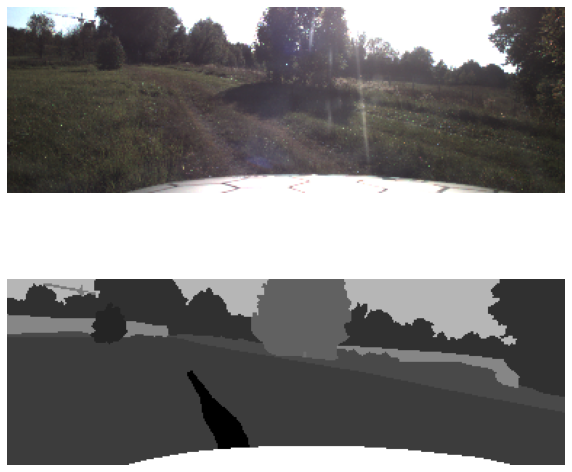

In [40]:
f, axs = plt.subplots(2,figsize=(10,10), gridspec_kw = {'wspace':0, 'hspace':0})

axs[0].imshow(X_train[0])
axs[0].axis('off')
axs[1].imshow(np.argmax(Y_train_id[0], axis = -1), cmap = 'gray')
axs[1].axis('off')
# axs[2].imshow(Y_train_ids[0])
# axs[2].axis('off')

In [144]:
x_train = np.array(X_train[:170])
y_train = np.array(Y_train_id[:170])


x_val = np.array(X_train[170:])
y_val = np.array(Y_train_id[170:])

In [45]:
print("Number of samples in x_train and x_val are %d and %d" % (x_train.shape[0], x_val.shape[0]))
print("Number of samples in y_train and Y_val are %d and %d" % (y_train.shape[0], y_val.shape[0]))

Number of samples in x_train and x_val are 170 and 30
Number of samples in y_train and Y_val are 170 and 30


In [46]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [47]:
#I have used batch size as 2 so that i won't run out of ram
batch_size = 2
# training data
train_dataset = train_loader.shuffle(len(x_train)).batch(batch_size)
# validation data
validation_dataset = val_loader.shuffle(len(x_val)).batch(batch_size)

# Define The Model

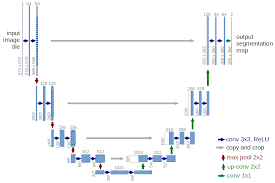

In [67]:
#Convolution block
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 4, padding = 'same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 4, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [68]:
#The encoder block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D(pool_size = (2,2))(x)
    return x, p

In [69]:
#Decoder block
def decoder_block(inputs, skip_connections, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, kernel_size = (2,2), strides = 2, padding = 'same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_connections])
    x = conv_block(x, num_filters)
    return x

In [70]:
#U-NET architecture
def unet(input_shape):
    Input = tf.keras.layers.Input(shape = input_shape) #128*384

    """Encoder Block"""
    s1, p1 = encoder_block(Input, 64) #64*192
    s2, p2 = encoder_block(p1, 128) #32*96
    s3, p3 = encoder_block(p2, 256) #16*48
    s4, p4 = encoder_block(p3, 512) #8*24

    """Bridge"""
    b1 = conv_block(p4, 1024) #8*24

    """Decoder Block"""
    d1 = decoder_block(b1, s4, 512) #16*48
    d2 = decoder_block(d1, s3, 256) #32*96
    d3 = decoder_block(d2, s2, 128) #64*192
    d4 = decoder_block(d3, s1, 64) #128*384

    Output = tf.keras.layers.Conv2D(24, (3,3), padding = 'same', activation = 'softmax')(d4)
    # Output = tf.argmax(Output, axis = -1)
    model = tf.keras.models.Model(Input, Output)
    return model

In [71]:
model = unet((128, 384, 3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 384, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 384, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 384, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 128, 384, 64) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

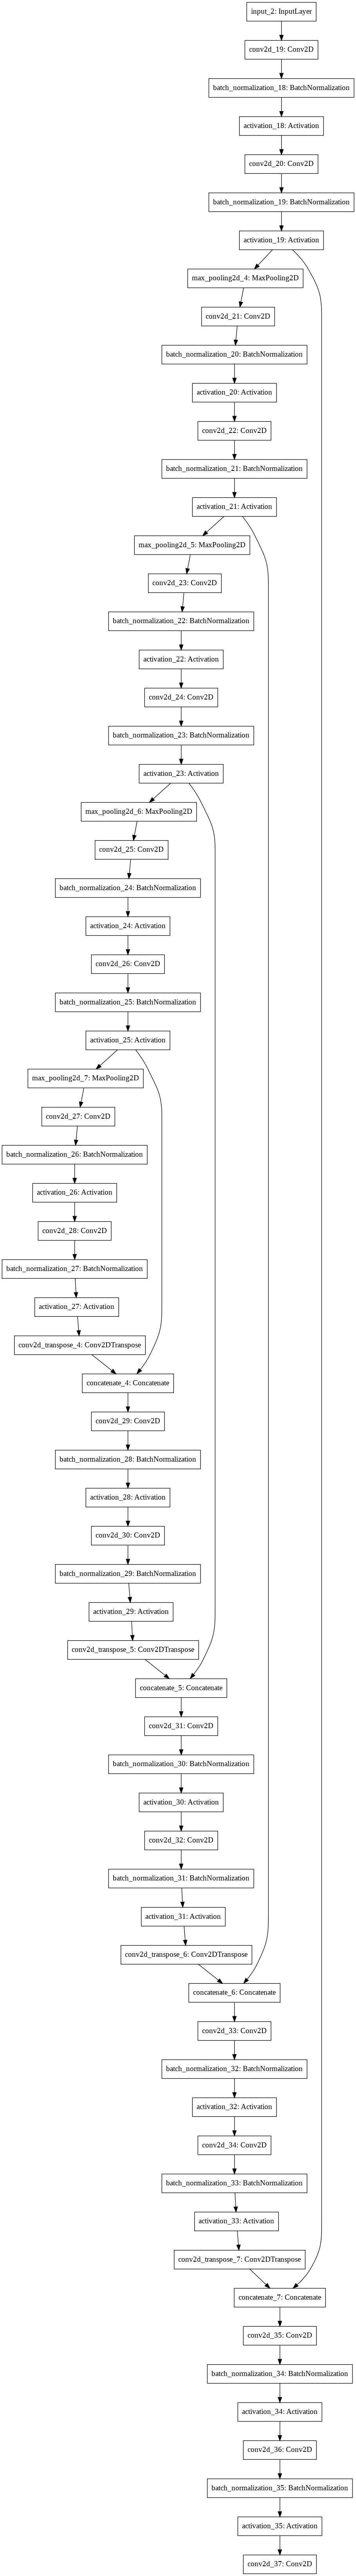

In [72]:
tf.keras.utils.plot_model(model)

In [76]:
initial_lr = 0.01

model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes = 24)]
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("semantic_segmentation2.ckpt", save_best_only = True)
t_board = tf.keras.callbacks.TensorBoard(log_dir = './logs/expr1',)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'max', verbose = 1,
                           restore_best_weights = True)

In [77]:
EPOCHS = 50
BATCH_SIZE = 2

In [78]:
model.fit(train_dataset,
          validation_data = validation_dataset,
          epochs = EPOCHS,
          steps_per_epoch = len(x_train)//BATCH_SIZE,
          validation_steps = len(x_val)//BATCH_SIZE,
          callbacks = [checkpoint_cb, t_board]
          )

Epoch 1/50
85/85 [==============================] - 73s 820ms/step - loss: 1.6230 - accuracy: 0.4743 - mean_io_u: 0.4792 - val_loss: 18.6254 - val_accuracy: 0.2189 - val_mean_io_u: 0.5231
INFO:tensorflow:Assets written to: semantic_segmentation2.ckpt/assets
Epoch 2/50
85/85 [==============================] - 68s 803ms/step - loss: 1.4694 - accuracy: 0.5042 - mean_io_u: 0.4792 - val_loss: 6.1154 - val_accuracy: 0.3225 - val_mean_io_u: 0.4889
INFO:tensorflow:Assets written to: semantic_segmentation2.ckpt/assets
Epoch 3/50
85/85 [==============================] - 68s 802ms/step - loss: 1.4271 - accuracy: 0.5265 - mean_io_u: 0.4792 - val_loss: 1.8048 - val_accuracy: 0.4181 - val_mean_io_u: 0.4792
INFO:tensorflow:Assets written to: semantic_segmentation2.ckpt/assets
Epoch 4/50
85/85 [==============================] - 68s 803ms/step - loss: 1.3754 - accuracy: 0.5372 - mean_io_u: 0.4792 - val_loss: 1.8866 - val_accuracy: 0.3860 - val_mean_io_u: 0.4792
Epoch 5/50
85/85 [=======================

In [87]:
img = tf.keras.preprocessing.image.load_img(X_train_path[1], target_size = (128, 384))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255.0
img = np.expand_dims(img, axis = 0)
img.shape
pred_mask = model.predict(img)[0]

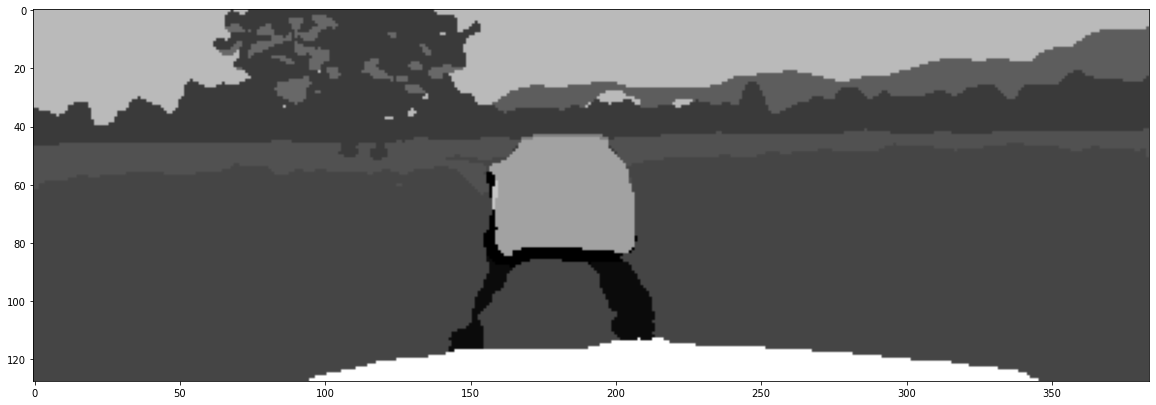

In [88]:
plt.figure(figsize = (20,20))
plt.imshow(tf.argmax(pred_mask.reshape(128,384,24), axis = -1), cmap = 'gray')

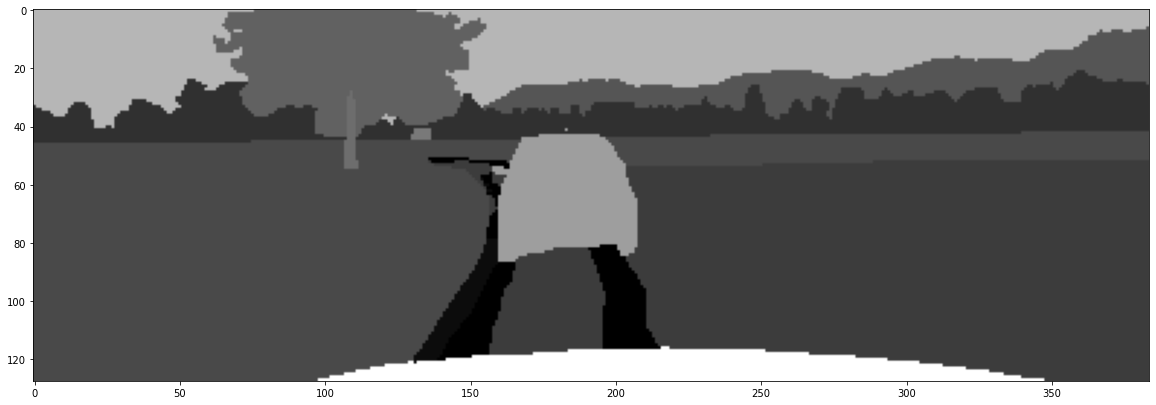

In [89]:
plt.figure(figsize = (20,20))
plt.imshow(tf.argmax(y_train[1], axis = -1), cmap = 'gray')

In [92]:
# !zip -r logs.zip logs/
# !zip -r semantic_segmentation2.ckpt.zip semantic_segmentation2.ckpt/

  adding: semantic_segmentation2.ckpt/ (stored 0%)
  adding: semantic_segmentation2.ckpt/assets/ (stored 0%)
  adding: semantic_segmentation2.ckpt/saved_model.pb (deflated 92%)
  adding: semantic_segmentation2.ckpt/keras_metadata.pb (deflated 95%)
  adding: semantic_segmentation2.ckpt/variables/ (stored 0%)
  adding: semantic_segmentation2.ckpt/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: semantic_segmentation2.ckpt/variables/variables.index (deflated 78%)


In [136]:
os.mkdir('test_labels_ids')

In [137]:
X_test_path = 'gdrive/MyDrive/bigthinx_ai_challange/test/'

In [138]:
X_test_path = [os.path.join(X_test_path, x) for x in os.listdir(X_test_path)]

In [139]:
X_test = np.array([read(i, path) for i, path in enumerate(X_test_path)])

In [140]:
mdl = unet((128, 384, 3))
mdl.load_weights('best_model.ckpt')

In [141]:
for test_image, path in zip(X_test,X_test_path):
  img = np.expand_dims(test_image, axis = 0)
  pred = mdl.predict(img)[0]
  pred = tf.argmax(pred.reshape(128,384,24), axis = -1)
  name = path.split('/')[-1]
  plt.imsave('./test_labels_ids/'+ str(name),pred, cmap = 'gray')

In [135]:
# !rm -rf test_labels_ids

In [142]:
!zip -r test_labels_ids.zip test_labels_ids

  adding: test_labels_ids/ (stored 0%)
  adding: test_labels_ids/1584364560825526272.png (stored 0%)
  adding: test_labels_ids/1567611285057811871.png (stored 0%)
  adding: test_labels_ids/1537962297875571911.png (stored 0%)
  adding: test_labels_ids/1528986265896406595.png (stored 0%)
  adding: test_labels_ids/1527246512981838592.png (stored 0%)
  adding: test_labels_ids/1567611047268862218.png (deflated 2%)
  adding: test_labels_ids/1567611078154391410.png (deflated 8%)
  adding: test_labels_ids/1539600588367745334.png (stored 0%)
  adding: test_labels_ids/1537962217925037218.png (deflated 1%)
  adding: test_labels_ids/1567611059367182571.png (deflated 2%)
  adding: test_labels_ids/1584362985216139264.png (deflated 0%)
  adding: test_labels_ids/1528986424990928832.png (stored 0%)
  adding: test_labels_ids/1539600835862860333.png (stored 0%)
  adding: test_labels_ids/1528986319122526746.png (stored 0%)
  adding: test_labels_ids/1567610723630367394.png (stored 0%)
  adding: test_labels